In [25]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

### Some basic functions to setup cards sampling and normalisation

In [39]:
if hasattr(np, 'float128'):
    DTYPE = np.float128
else:
    DTYPE = np.float64
ACTIONS = {0: 'p', 1: 'b'}  # PASS: 0, BET: 1

In [40]:
def get_cards():
    cards = [1, 2, 3]
    card_1 = random.choice(cards)
    cards.remove(card_1)
    card_2 = random.choice(cards)
    return card_1, card_2

In [41]:
def normalize(array):
    array = np.array(array, dtype=DTYPE)
    sum_positive = np.sum(np.maximum(array, 0))
    if sum_positive > 0:
        return np.maximum(array, 0) / sum_positive
    return np.ones_like(array) / len(array)

In [42]:
def print_strategy(strategy):
    """Print the strategy profile."""
    print("*" * 25)
    for key in sorted(strategy.keys()):
        print(f"{key}: {strategy[key]}")
    print("*" * 25)

### Calculation and History Functions

In [43]:
def calculate_utility(history, cards):
    if history[-2:] == 'pp':
        return (1, -1) if cards[0] > cards[1] else (-1, 1)
    if history[-2:] == 'bb':
        return (2, -2) if cards[0] > cards[1] else (-2, 2)
    if history[-2:] == 'bp':
        return (-1, 1) if len(history) == 3 else (1, -1)
    if history[-2:] == 'pb':
        return (-1, 1)

In [44]:
def calculate_expected_value(history, probability, cards, strategy, exp_values):
    player = len(history) % 2 + 1
    info_set = f"{cards[player - 1]}{history}"

    if is_terminal(history):
        exp_values[info_set] = probability * calculate_utility(history, cards)[0]
        return

    for action in (0, 1):
        new_history = history + ACTIONS[action]
        calculate_expected_value(new_history, probability * strategy[info_set][action], cards, strategy, exp_values)

In [45]:
def is_terminal(history):
    return len(history) >= 2 and (history[-2:] in ('pp', 'bb', 'bp') or len(history) == 3)

### Counter-Factual Regret Minimsation
Updating History and Strategy

In [46]:
def cfr(history, updating_player, p1_prob, p2_prob, cards, strategy, strategy_sum, regret_sum):
    player = len(history) % 2 + 1
    opponent = 3 - player

    if is_terminal(history):
        return calculate_utility(history, cards)[player - 1]

    info_set = f"{cards[player - 1]}{history}"

    action_values = np.zeros(2)
    for action in (0, 1):
        new_history = history + ACTIONS[action]
        if player == 1:
            action_values[action] = -cfr(new_history, updating_player, p1_prob * strategy[info_set][action], p2_prob, cards, strategy, strategy_sum, regret_sum)
        else:
            action_values[action] = -cfr(new_history, updating_player, p1_prob, p2_prob * strategy[info_set][action], cards, strategy, strategy_sum, regret_sum)

    strategy_value = np.dot(action_values, strategy[info_set])

    if player == updating_player:
        opponent_prob = p2_prob if player == 1 else p1_prob
        regrets = opponent_prob * (action_values - strategy_value)
        regret_sum[info_set] += regrets
        strategy_sum[info_set] += (p1_prob if player == 1 else p2_prob) * strategy[info_set]
        strategy[info_set] = normalize(regret_sum[info_set])

    return strategy_value

In [47]:
def run_cfr_with_tracking(num_iterations, track_interval=1000, reset_interval=100000):

    # Then, use this type when initializing arrays:
    strategy = defaultdict(lambda: np.array([0.5, 0.5], dtype=DTYPE))
    strategy_sum = defaultdict(lambda: np.zeros(2, dtype=DTYPE))
    regret_sum = defaultdict(lambda: np.zeros(2, dtype=DTYPE))

    # Approximate Nash equilibrium for Kuhn Poker
    nash_equilibrium = {
        '1': np.array([2/3, 1/3]),
        '2': np.array([1, 0]),
        '3': np.array([1, 0]),
        '1p': np.array([1, 0]),
        '2p': np.array([2/3, 1/3]),
        '3p': np.array([0, 1]),
    }

    distances = []
    iterations = []

    for i in range(1, num_iterations + 1):
        for player in (1, 2):
            cfr("", player, 1, 1, get_cards(), strategy, strategy_sum, regret_sum)

        if i % reset_interval == 0:
            # Reset and recalculate average strategy
            average_strategy = {k: normalize(v) for k, v in strategy_sum.items()}
            strategy_sum = defaultdict(lambda: np.zeros(2, dtype=DTYPE))
            for info_set, probs in average_strategy.items():
                strategy_sum[info_set] = probs * i

        if i % track_interval == 0:
            average_strategy = {k: normalize(v) for k, v in strategy_sum.items()}
            distance = calculate_nash_distance(average_strategy, nash_equilibrium)
            distances.append(distance)
            iterations.append(i)

    final_strategy = {k: normalize(v) for k, v in strategy_sum.items()}
    return final_strategy, iterations, distances

In [48]:
def calculate_nash_distance(average_strategy, nash_equilibrium):
    total_relative_error = 0
    for info_set in nash_equilibrium:
        if info_set in average_strategy:
            current = average_strategy[info_set]
            nash = nash_equilibrium[info_set]
            relative_error = np.sum(np.abs((current - nash) / (nash + 1e-15)))  # Add small epsilon to avoid division by zero
            total_relative_error += relative_error
    return total_relative_error

In [49]:
def plot_convergence(iterations, distances):
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, distances)
    plt.title('Convergence to Nash Equilibrium')
    plt.xlabel('Iterations')
    plt.ylabel('Distance to Nash Equilibrium')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

Expected utility for first player: -0.055517039883032526
*************************
1: [0.92770426 0.07229574]
1b: [9.99851323e-01 1.48676777e-04]
1p: [0.65057217 0.34942783]
1pb: [9.99918215e-01 8.17852605e-05]
2: [0.99850478 0.00149522]
2b: [0.63512269 0.36487731]
2p: [9.99375372e-01 6.24628198e-04]
2pb: [0.59234047 0.40765953]
3: [0.78144941 0.21855059]
3b: [1.52671756e-04 9.99847328e-01]
3p: [4.58015267e-04 9.99541985e-01]
3pb: [9.51854637e-05 9.99904815e-01]
*************************


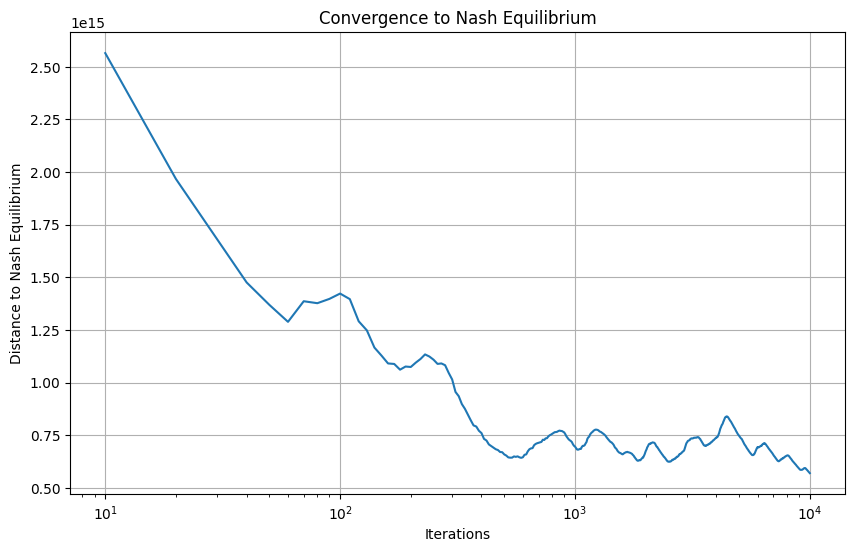

In [59]:
NUM_ITERATIONS = 10000
TRACK_INTERVAL = 10

final_strategy, iterations, distances = run_cfr_with_tracking(NUM_ITERATIONS, TRACK_INTERVAL)

total_exp_value = 0
for c1 in (1, 2, 3):
    for c2 in (1, 2, 3):
        if c1 != c2:
            exp_values = {}
            calculate_expected_value("", 1/6, [c1, c2], final_strategy, exp_values)
            total_exp_value += sum(exp_values.values())

print(f"Expected utility for first player: {total_exp_value}")

print_strategy(final_strategy)
plot_convergence(iterations, distances)